In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RC.csv'
fr = pd.read_csv(FILE)

V = np.array(fr['V (V)'])
t = np.array(fr['t (us)']) * 10**-6
R = 996 # ohm
sigmaR = 1 # incertezza associata al multimetro
T = 2* (10**-3) # 2ms impostato dall'oscilloscopio TODO: verificare se vale la pena 
sigmaV = 0.2 / np.sqrt(12)#  0.08 / np.sqrt(12) # uniform distribution
# Vg = 4.95 # V

$
V_r(t) = \frac{2V_g}{{1 + e^{-\frac{T}{2\tau}}}}e^{-\frac{t}{\tau}} 
$

where $\tau = R \cdot C$

In [11]:
def VR(t, τ, Vg):
    return 2*Vg*np.exp(-t/τ)/(1+np.exp(-T/(2*τ)))

C_guess = 99 * 10**-9 # 0.1 nF
Vg_guess = 4.95
i = Interpolazione(t,V,VR, sigmaV, p0=[R*C_guess, Vg_guess])
print(i)

print('----------------------- RESULT -----------------------')
# estrazione dei valori di C e Vg
Vg = i.bval[1]
sigmaVg = i.sigma_bval[1]
τ = i.bval[0]
sigmaτ = i.sigma_bval[0]

C = τ / R
sigmaC = np.sqrt((sigmaτ / R)**2 + (τ * sigmaR / R**2)**2)

print('C = ',final_val(C, sigmaC,exp=-9,decimals=1,udm='F')) # TODO: verificare quanti decimali siano necessari e controllare propagazione errori
print('Vg = ',final_val(Vg, sigmaVg,decimals=2,udm='V'))

   
Parameters: [1.04232457e-04 4.70030682e+00] 
Sigma parameters: [2.78747074e-07 8.34646896e-03]

sigmaY: 0.05773502691896258

chiquadro ridotto: 0.23
df: 40
pvalue: 100.0%
covariance matrix: [[ 7.04761281e-14 -1.53025138e-09]
 [-1.53025138e-09  6.31868881e-05]]    

----------------------- RESULT -----------------------
C =  (104.7 ± 0.3)e-9 F
Vg =  4.7 ± 0.01 V


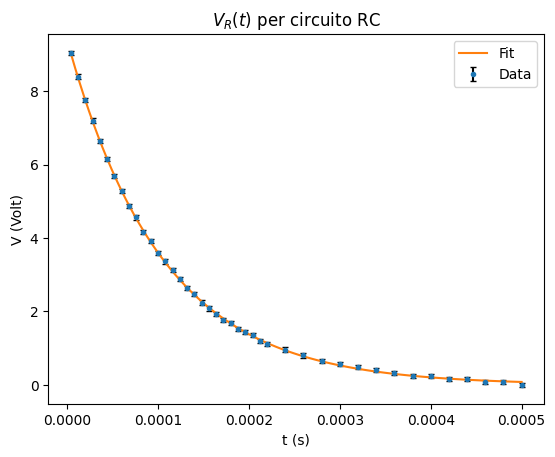

In [5]:
plt.errorbar(t, V, yerr=sigmaV, fmt='.',ecolor='black',label='Data',capsize=2)
plt.plot(i.x_best,i.y_best,label='Fit')

plt.xlabel('t (s)')
plt.ylabel('V (Volt)')
plt.title('$V_R(t)$ per circuito RC')
plt.legend()
plt.show()

$
V_c(t) = V_g - V_r
$

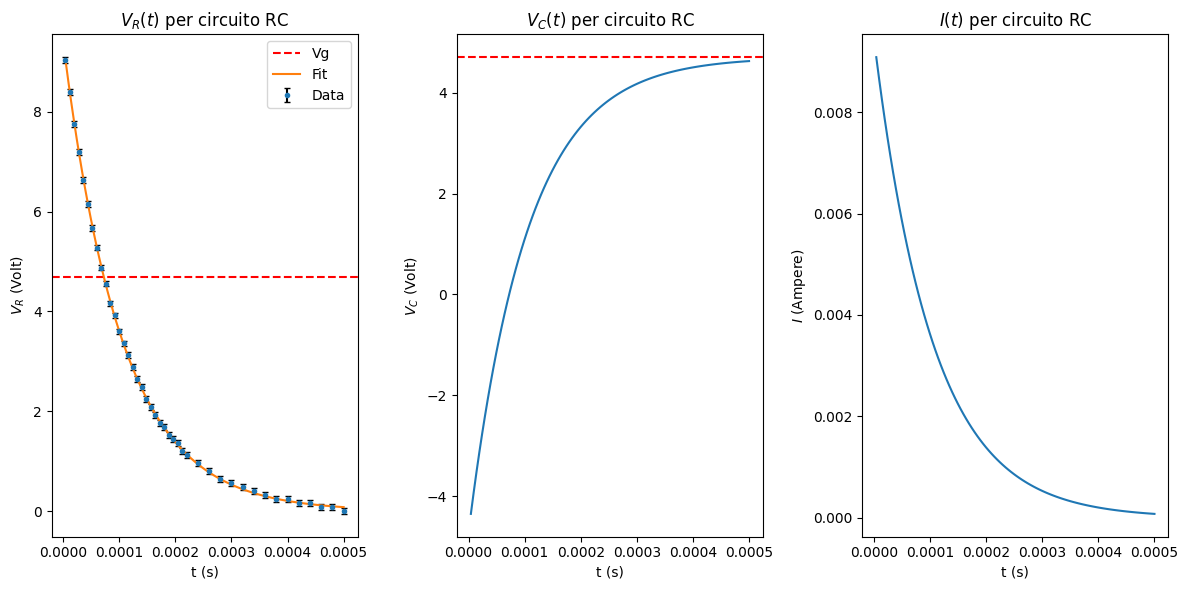

In [10]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
# Plot on the left
ax1.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax1.errorbar(t, V, yerr=sigmaV, fmt='.', ecolor='black', label='Data', capsize=2)
ax1.plot(i.x_best, i.y_best, label='Fit')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('$V_R$ (Volt)')
ax1.set_title('$V_R(t)$ per circuito RC')
ax1.legend()

# Plot on the right
V_c = Vg - i.y_best
ax2.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax2.plot(i.x_best, V_c)
ax2.set_xlabel('t (s)')
ax2.set_ylabel('$V_C$ (Volt)')
ax2.set_title('$V_C(t)$ per circuito RC')

# Plot on the third
I = i.y_best / R
ax3.plot(i.x_best, I)
ax3.set_xlabel('t (s)')
ax3.set_ylabel('$I$ (Ampere)')
ax3.set_title('$I(t)$ per circuito RC')

plt.tight_layout()
plt.show()